## [0] Setup

### 0.1 Get the dependencies

In [104]:
%%capture # hide the output

!conda update --all --yes
!conda install cudnn --yes

!pip install --upgrade pip
!pip install tensorflow-gpu
!pip install imutils
!pip install tqdm
!pip install pyyaml h5py
!pip install tensorflow-hub

### 0.2 Import the dependencies

In [105]:
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import glob
import imageio
import random
import math
import shutil
import requests
import skimage

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import tensorflow_hub as hub
from collections import defaultdict

# create a directory if it doesn't already exist
make_dir = lambda path: os.path.exists(path) or os.makedirs(path)

### 0.3 Constants

In [103]:
IMG_HEIGHT = 224 #300 
IMG_WIDTH = 224 # 300
train_pct = 0.8
batch_size = 24

## [1] Get the Data

### 1.1 Create directories for the test and train data

In [106]:
!rm -rf data
make_dir('data')
make_dir('data/train')
make_dir('data/test')

### 1.1 Get the provided dataset

#### 1.1.1 Download and unzip the images

In [107]:
if not os.path.exists('train.zip'):
    !curl https://ecs.victoria.ac.nz/foswiki/pub/Courses/COMP309_2019T2/Assignments/Train_data_2019.zip -o train.zip
!unzip -oq train.zip -d data

#### 1.1.2 Split the images using 309 as a seed

In [108]:
random.seed(309)
for label_dir in glob.glob('data/Train_data/*'):
    label = label_dir.split('/')[-1]
    make_dir(f'data/train/{label}')
    make_dir(f'data/test/{label}')
    
    images = glob.glob(f'{label_dir}/*')
    random.shuffle(images)
    
    split_index = math.floor(len(images) * train_pct)
    for i, image in tqdm(enumerate(images), label):
        train_or_test = 'train' if i < split_index else 'test'
        new_path = image.replace('Train_data', train_or_test)
        shutil.move(image, new_path)

# clean-up the unzipped directory (will be empty)
!rm -rf data/Train_data
!rm -rf data/__MACOSX

### 1.2 Get images from ImageNet

#### 1.2.1 Fetch the ImageNet urls

In [109]:
imagenet_urls_path = 'imagenet_urls/fall11_urls.txt'
if not os.path.exists(imagenet_urls_path):
    !rm -rf imagenet_urls 
    !mkdir imagenet_urls

    # n.b. the main site is down: use a mirror
    !wget https://v.im.cyut.edu.tw/ftp/18/imagenet_fall11_urls.tgz -O imagenet_urls/imagenet_fall11_urls.tgz
    !tar -xvf imagenet_fall11_urls.tgz -C imagenet_urls

raw_image_urls = list(open(imagenet_urls_path, encoding='ISO-8859-1'))

#### 1.2.2 Find images for each class

In [110]:
word_net_ids = {
    'strawberry': ['n07745940'],
    'cherry': ['n07757132', 'n07757312', 'n07757874', 'n07757990'],
    'tomato': ['n07734292', 'n07734292']
}

image_urls_by_class = defaultdict(list)
for line in tqdm(raw_image_urls):
    image_id = line.split('\t')[0].split('_')[0]
    image_url = line.split('\t')[1].strip()
    
    for class_name, ids in word_net_ids.items():
        if image_id in ids:
            image_urls_by_class[class_name] += [image_url]

#### 1.2.3 Download applicable images from ImageNet
Note: images from Flickr are filtered out as they may be in the evaluation data set.

In [111]:
try:
    dead_images
except:
    dead_images = [] # don't retry these again this session
    
for class_name, urls in image_urls_by_class.items():
    # filter out images from flickr
    not_flickr = [url for url in urls if 'flickr' not in url]
    for i, url in tqdm(list(enumerate(not_flickr)), class_name):
        extension = url.split('.')[-1].lower()
        if extension not in ['jpg', 'jpeg', 'png']: continue
        
        out_image_path = f'data/train/{class_name}/image_net_{i:03}.jpg'
        if os.path.exists(out_image_path) or url in dead_images:
            continue
        
        try:
            response = requests.get(url, timeout=(2, 5), allow_redirects=False)
            assert response.status_code == 200
        except (
            AssertionError,
            requests.exceptions.ReadTimeout,
            requests.exceptions.ConnectionError,
            requests.exceptions.Timeout
        ): # can't download image
            dead_images += [url]
            continue
            
        temp_file_name = f'temp.{extension}'
        open(temp_file_name, 'wb').write(response.content)
        
        try:
            image = imageio.imread(temp_file_name)
            if image.shape[-1] == 4:
                image = skimage.color.rgba2rgb(image)
            
            if image.dtype != np.uint8:
                image = (image * 255).astype(np.uint8)
            imageio.imwrite(out_image_path, image)
        except ValueError: # isn't a valid image
            dead_images += [url]
            continue
        finally:
            os.remove(temp_file_name)

### 1.3 Process images from Google Images

In [112]:
# this is manually uploaded
!unzip -oq google_images.zip

all_images = enumerate(glob.glob('google_images/*/*'))
for i, image_path in tqdm(list(all_images)):
    class_name = image_path.split('/')[-2].replace('cherry_tomato', 'tomato')
    
    image = imageio.imread(image_path)
    imageio.imwrite(f'data/train/{class_name}/google_images_{i:04}.jpg', image)
    
!rm -rf google_images

In [96]:
for class_name in ['tomato', 'cherry', 'strawberry']:
    print(class_name, len(glob.glob(f'data/train/{class_name}/*')))

tomato 2299
cherry 1623
strawberry 1637


## [2] Pre-processing

### 2.1 Specify the data augmentation to use

In [117]:
data_augmentation = dict(
    horizontal_flip=True,
    rotation_range=35,
    zoom_range=0.25,
    width_shift_range=0.15,
    height_shift_range=0.1,
    shear_range=25,
    brightness_range=[0.75, 1.25],
)

### 2.2 Build the ImageDataGenerators
Note: the test data isn't augmented here, but TTA is later implemented

In [118]:
print('Train:', end=' ')
train_data_gen = ImageDataGenerator(rescale=1.0/255, **data_augmentation).flow_from_directory(
    batch_size=batch_size,
    directory='data/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
)

print('Test:', end=' ')
test_data_gen = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    batch_size=batch_size,
    directory='data/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
)

Train: Found 5536 images belonging to 3 classes.
Test: Found 900 images belonging to 3 classes.


### 2.3 Visualise the data augmentation

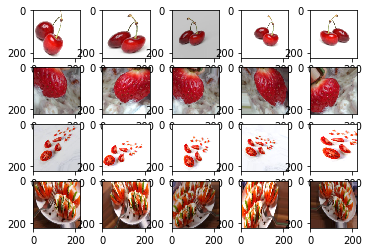

In [119]:
_, axes = plt.subplots(4, 5)

for image in range(axes.shape[0]):
    for example in tqdm(range(axes.shape[1])):
        axes[image,example].imshow(train_data_gen[0][0][image])

### [3] Training

### 3.1 Create a transfer learning model

In [120]:
train_histories = []

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False # freeze the pre-trained bit

# wrap the model in a sequential model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.AveragePooling2D(),
    Flatten(),
    Dropout(0.25),
    Dense(3, activation='softmax'),
])

### 3.2 Train the trail of the model

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

r = model.fit_generator(
    train_data_gen,
    validation_data=test_data_gen,
    epochs=15,
)

train_histories.append(r.history)

### 3.3 Unfreeze some of the pre-trained model and continue training

In [98]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

r = model.fit_generator(
    train_data_gen,
    validation_data=test_data_gen,
    initial_epoch=15,
    epochs=30,
)

train_histories.append(r.history)

Epoch 6/15
150/150 [==============================] - 91s 610ms/step - loss: 0.7110 - accuracy: 0.8653 - val_loss: 1.1515 - val_accuracy: 0.8233
Epoch 7/15
150/150 [==============================] - 87s 580ms/step - loss: 0.6324 - accuracy: 0.8839 - val_loss: 1.0386 - val_accuracy: 0.8244
Epoch 8/15
150/150 [==============================] - 87s 581ms/step - loss: 0.5957 - accuracy: 0.8811 - val_loss: 1.0002 - val_accuracy: 0.8344
Epoch 9/15
150/150 [==============================] - 86s 573ms/step - loss: 0.6212 - accuracy: 0.8728 - val_loss: 1.0192 - val_accuracy: 0.8300
Epoch 10/15
150/150 [==============================] - 89s 595ms/step - loss: 0.5947 - accuracy: 0.8800 - val_loss: 0.9764 - val_accuracy: 0.8300
Epoch 11/15
150/150 [==============================] - 86s 574ms/step - loss: 0.5229 - accuracy: 0.8917 - val_loss: 1.0158 - val_accuracy: 0.8244
Epoch 12/15
150/150 [==============================] - 87s 580ms/step - loss: 0.5040 - accuracy: 0.8869 - val_loss: 0.9736 - val

### 3.4 Unfreeze more of the pre-trained model and continue training

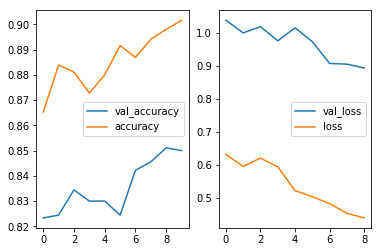

In [99]:
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=3e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

r = model.fit_generator(
    train_data_gen,
    validation_data=test_data_gen,
    initial_epoch=15,
    epochs=30,
)

train_histories.append(r.history)